In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

## 1. Introducción

El dataset utilizado para este trabajo es sobre "fraudes en pagos en linea", este dataset tiene 9 caractersiticas de entrada y 1 eteqieuta de salida. El objetivo del trabajo es realizar un analisis del dataset y determinar un modelo que maximice la ganancia de la empresa.

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

## 2. Desarrollo

### <strong>2.1. Análisis</strong>

#### 2.1.1. Lectura y vista de primeras filas de Dataset

In [3]:
data = pd.read_csv("data.csv",sep=",")

data.shape

(6362620, 11)

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### 2.1.2. Busqueda de datos Nulos

Se observa que el dataset no tiene datos nulos(NaN)

In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### 2.1.3. Tipo de Datos

El dataset tiene tres tipos de datos : int64(numerico),float64(numerico) y object(categorico)

In [6]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

#### 2.1.4. Vista de distribusciones de datos

Se observa que existe relaciones fuertes entre las variables "amount" y "newbalanceDest", "oldbalanceDest" y "newbalanceDest"

<AxesSubplot:>

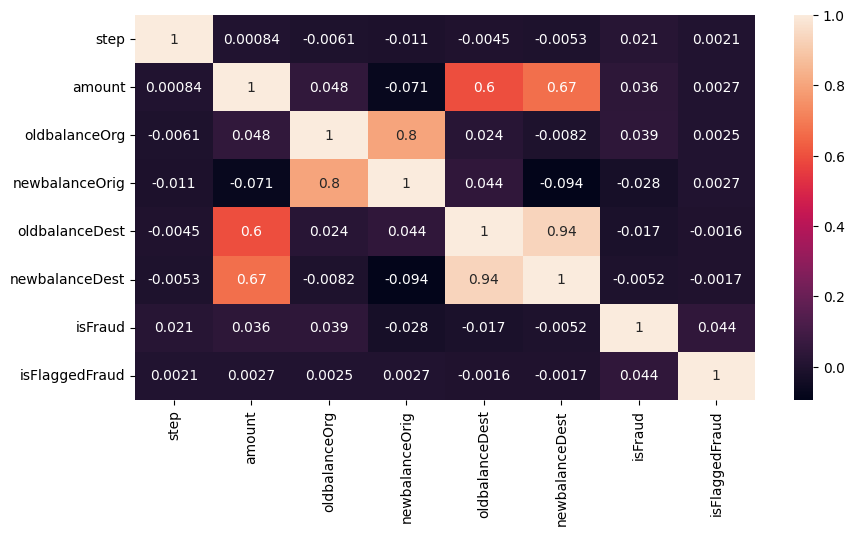

In [7]:
corr = data.corr(method='spearman')

plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

#### 2.1.5. Analizar filas que no coinciden con las cuentas

Nota: Debido a que esto representa mas del 85% del dataset no se eliminan las filas, se debe verificar si la data adquirida tiene un factor relevante que puede explicar estas anomalias

In [8]:
cuenta_origen = np.sum((data['oldbalanceOrg']-data['amount'])!=data['newbalanceOrig'])

print("Cantidad de Filas que no coincide el balance: ", cuenta_origen,', esto representa',np.round(cuenta_origen/(data.shape[0]),3)*100,'% del total de datos')


Cantidad de Filas que no coincide el balance:  5413997 , esto representa 85.1 % del total de datos


#### 2.1.6. Visualizar balance de datos

Se observa que el target tiene un desbalance muy grande de datos con una relacion de 700

In [9]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

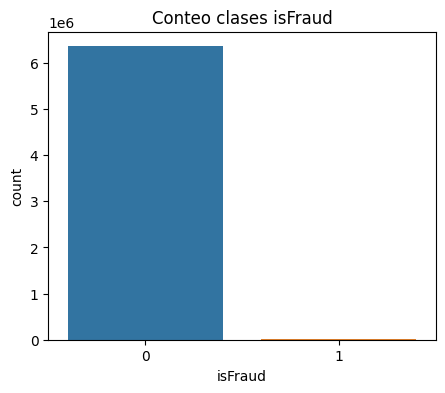

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x='isFraud', data=data).set(title="Conteo clases isFraud")
plt.show()


### <strong>2.2. Procesamiento</strong>

#### 2.2.1. Eliminar atributos no relevantes

Se elimina los atributos "isFlaggedFraud", "nameOrig" y "nameDest" debido a que no representan informacion relevante en relacion con el target

In [11]:
data = data.drop(['isFlaggedFraud','nameOrig','nameDest'],axis=1)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


#### 2.2.2. Codificar atributos no numéricos

Se visualiza los tipos de datos del dataset procesado

In [12]:
data.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Se codifica el atributo "type" ya que es el unica columna que es de tipo objeto que son los tipos de pago o transacciones

In [13]:
encoder = preprocessing.LabelEncoder()
data['type'] = encoder.fit_transform(data['type'])
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


#### 2.2.3. Aplicar undersampling, se elige undersampling por los siguiente

- Para el objetivo se necesita mejor deteccion de Fraude positivo
- Disminuir la carga computacional de los modelos de entrenamiento

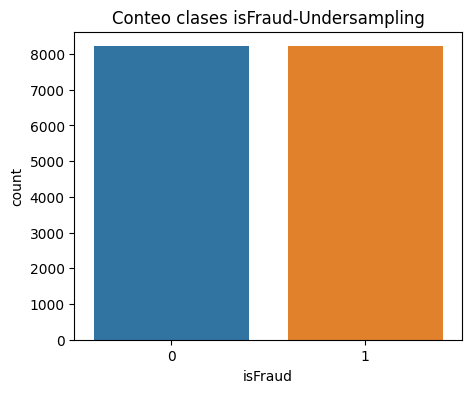

In [14]:
y = data.loc[:, ['isFraud']]
X = data.drop(['isFraud'],axis=1)

rus = RandomUnderSampler(random_state = 10)
X_under, y_under = rus.fit_resample(X,y)

plt.figure(figsize=(5,4))
sns.countplot(x='isFraud', data=y_under).set(title="Conteo clases isFraud-Undersampling")
plt.show()

### <strong>2.3. Entrenamiento</strong>

#### 2.3.1. Particionar train y test

Se realiza el particionamiento de train y test con un porcentaje de 25%

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under, test_size = 0.25, random_state = 42)

print('Tamaño de train x :', X_train.shape[0],'train y: ', y_train.shape[0])
print('Tamaño de test  x  :',X_test.shape[0], 'train y: ', y_test.shape[0])

Tamaño de train x : 12319 train y:  12319
Tamaño de test  x  : 4107 train y:  4107


#### 2.3.2. Modelo Random Forest

El modelo entrenado de clasificacion por Random Forest da como resultado un clasificador equilibrado.
- Bajo porcenteje de falsos negativos

C:\Users\PC-01\AppData\Local\Temp\ipykernel_21112\2250970469.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


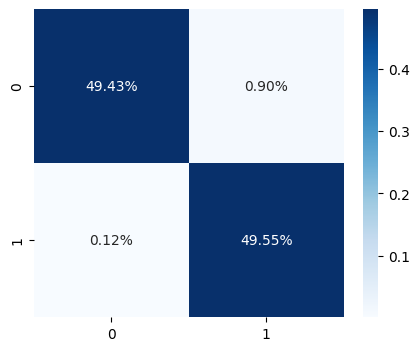

In [16]:
rf = RandomForestClassifier(n_estimators = 100, 
                            criterion='gini',
                            max_features='sqrt',
                            bootstrap=True,
                            max_samples=2/3,
                            oob_score=True,
                            random_state = 42)
rf.fit(X_train, y_train)

prediction = rf.predict(X_test)
cf_matrix_1 = confusion_matrix(y_test, prediction)


plt.figure(figsize=(5,4))
sns.heatmap(cf_matrix_1/np.sum(cf_matrix_1), annot=True, fmt='.2%', cmap='Blues')
plt.show()


In [17]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2067
           1       0.98      1.00      0.99      2040

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



#### 2.3.3 Molde Decision Tree

El modelo de "Decision Tree"

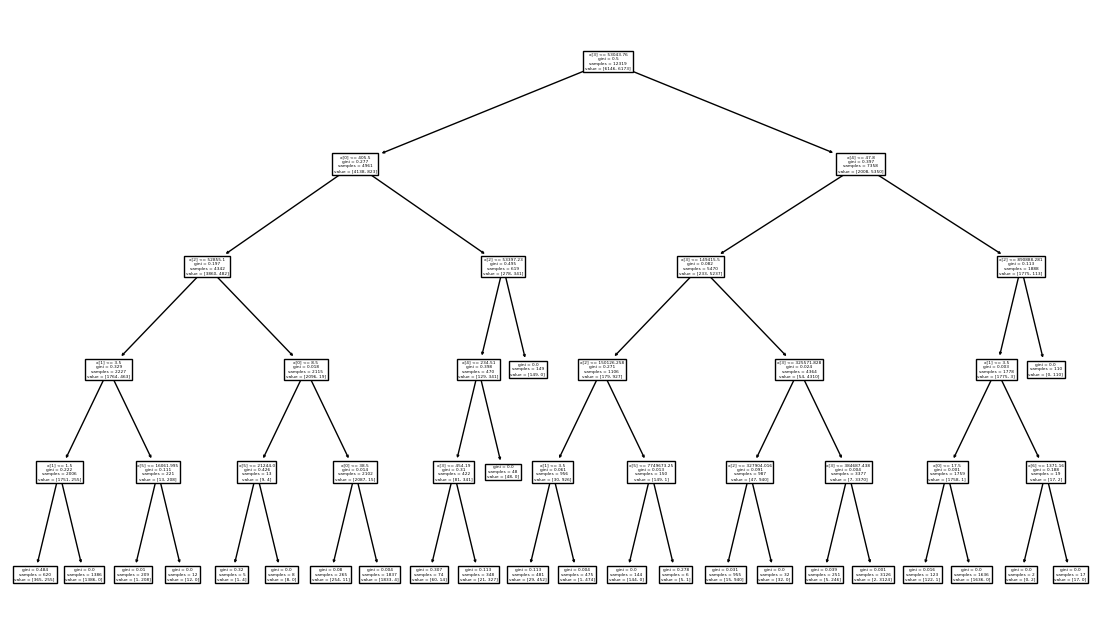

In [54]:
model_tree = DecisionTreeClassifier(max_depth=5,
                                    criterion='gini')
model_tree.fit(X_train, y_train)
plt.figure(figsize=(14,8))
plot_tree(model_tree)
plt.show()

<AxesSubplot:>

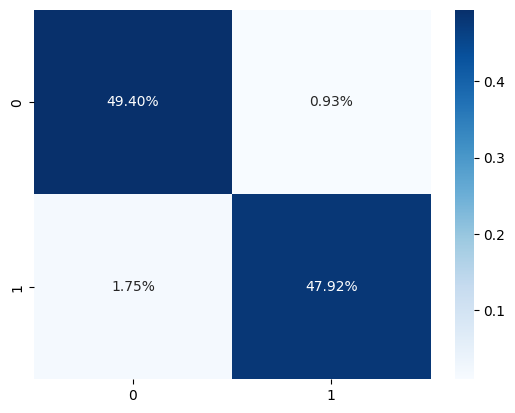

In [53]:
model_tree.score(X_train, y_train)
prediction2= model_tree.predict(X_test)

cf_matrix_2 = confusion_matrix(y_test, prediction2)
sns.heatmap(cf_matrix_2/np.sum(cf_matrix_2), annot=True, fmt='.2%', cmap='Blues')

In [55]:
print(classification_report(y_test, prediction2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2067
           1       0.98      0.96      0.97      2040

    accuracy                           0.97      4107
   macro avg       0.97      0.97      0.97      4107
weighted avg       0.97      0.97      0.97      4107



## 3. Conclusión

- El modelo de Random Forest obtiene mejores resultados en clasificacion, esto permite equilibrar y obtener ganancias con menos falsos negativos.

- Existen vas datos para deteccion de "no es fraude" pero este no tan relevante para maximizar las ganancias, por ello se aplica undersampling.

- Existen filas donde los atributos de balance antes y despues de la transferencia no coinciden, pero no se eliminan ya que representa casi el 80% de los datos.

- Se eliminaron los atributos que identifican a las personas de origen y destino en una transferencia.